# Resultados

En esta notebook analizamos resultados pero centrando en aquellos marcados como "regionales".

In [54]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_regionalism = pd.read_csv("../data/regionalisms/check_regionalisms_annotated.csv", index_col=0)

df_regionalism = df_regionalism.rename(columns={"CHECK": "is_regional"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Nos quedamos con los índices de los tweets que tengan slang.



In [55]:
indices = df_regionalism[df_regionalism["is_regional"] > 0].index

len(indices)

1547

In [72]:

%load_ext autoreload
%autoreload 2
from rioplatense_hs.openai import get_completion
import pandas as pd
from glob import glob
from rioplatense_hs.preprocessing import labels

pd.options.display.max_colwidth = 1000
#df_train.loc[df_train["LGBTI"] > 0, ["title", "text", "text_label"]].sample(20)

files = {
    #"one-shot": sorted(glob("../data/test*pred*1shot.csv")),
    "gpt-3.5": sorted(glob("../data/test*pred*12shot.csv")),
    "beto": sorted(glob("../data/test*beto.csv")),
    "aya": sorted(glob("../data/test*aya_.csv")),
    "mixtral": sorted(glob("../data/test*mixtral.csv")),
}

assert len({len(value) for value in files.values()}) == 1

dfs = {k: pd.concat([pd.read_csv(f, index_col=0) for f in v]) for k, v in files.items()}



pred_labels = [f"PRED_{label}" for label in labels]
score_labels = [f"SCORE_{label}" for label in labels]

dfs["beto"][score_labels] = dfs["beto"][pred_labels]
dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)

# Me quedo sólo con los que tienen regionalismos

dfs_regional = {k: v[v.index.isin(indices)].copy() for k, v in dfs.items()}
print("ALL")
print({k: len(v) for k, v in dfs.items()})
print("REGIONAL")
print({k: len(v) for k, v in dfs_regional.items()})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ALL
{'gpt-3.5': 5670, 'beto': 5670, 'aya': 5670, 'mixtral': 5670}
REGIONAL
{'gpt-3.5': 1547, 'beto': 1547, 'aya': 1547, 'mixtral': 1547}


In [73]:
from rioplatense_hs.preprocessing import labels as all_labels
labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]


pred_labels = [f"PRED_{label}" for label in labels]

all_pred_labels = [f"PRED_{label}" for label in all_labels]

Chequear que tengan todas la misma long

In [74]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score


def get_metrics(dfs):
    metrics = []
    for name, df in dfs.items():
        print(name)
        for label in tqdm(all_labels):

            for metric in {"precision", "recall", "f1"}:
                if metric == "precision":
                    score = precision_score
                elif metric == "recall":
                    score = recall_score
                elif metric == "f1":
                    score = f1_score


                gold_labels = df[label].values
                preds = df[f"PRED_{label}"].values

                bst = Bootstrap(metric=score, num_bootstraps=150)

                bst_scores = bst.run(preds, gold_labels)

                for score in bst_scores:
                    metrics.append(
                        {
                            "model": name,
                            "label": label,
                            "metric": metric,
                            "score": score,
                        }
                    )

    return pd.DataFrame(metrics)

all_metrics = get_metrics(dfs)
regional_metrics = get_metrics(dfs_regional)

gpt-3.5


  0%|          | 0/8 [00:00<?, ?it/s]

beto


  0%|          | 0/8 [00:00<?, ?it/s]

aya


  0%|          | 0/8 [00:00<?, ?it/s]

mixtral


  0%|          | 0/8 [00:00<?, ?it/s]

gpt-3.5


  0%|          | 0/8 [00:00<?, ?it/s]

beto


  0%|          | 0/8 [00:00<?, ?it/s]

aya


  0%|          | 0/8 [00:00<?, ?it/s]

mixtral


  0%|          | 0/8 [00:00<?, ?it/s]

In [77]:



diff = regional_metrics.groupby(["model", "label", "metric"]).agg("mean") - all_metrics.groupby(["model", "label", "metric"]).agg("mean")

diff = diff.reset_index()

In [98]:
agg_regional = regional_metrics.groupby(["model", "label", "metric"]).agg("mean")
agg_all = all_metrics.groupby(["model", "label", "metric"]).agg("mean")

# Build a single dataframe

agg_regional["type"] = "regional"
agg_all["type"] = "all"

agg = pd.concat([agg_regional, agg_all])

agg = agg.reset_index()

# Keep only f1

agg = agg[agg["metric"] == "f1"]

del agg["metric"]

# Build a df whose rows are the labels, and for each model / type we have a column

agg = agg.pivot_table(index="label", columns=["model", "type"], values="score")

# Add macro average as a row

agg.loc["macro"] = agg.mean()

agg

model         aya            beto          gpt-3.5          mixtral         
type          all regional    all regional     all regional     all regional
label                                                                       
APPEARANCE 0.3210   0.3391 0.7581   0.7945  0.5172   0.5325  0.6190   0.6716
CLASS      0.1171   0.2003 0.5775   0.6732  0.3448   0.4739  0.2376   0.3602
CRIMINAL   0.2898   0.3910 0.7064   0.7628  0.4050   0.5073  0.4380   0.4914
DISABLED   0.1058   0.1182 0.5977   0.6510  0.3319   0.3513  0.3235   0.3697
LGBTI      0.2283   0.2533 0.4575   0.4722  0.5365   0.4887  0.5357   0.4930
POLITICS   0.0873   0.1878 0.5945   0.6882  0.2539   0.3520  0.1433   0.2486
RACISM     0.4883   0.4593 0.7471   0.7012  0.6099   0.6400  0.5801   0.6091
WOMEN      0.1808   0.2579 0.4299   0.5108  0.3169   0.4086  0.2508   0.3682
macro      0.2273   0.2759 0.6086   0.6567  0.4145   0.4693  0.3910   0.4515

In [ ]:
from rioplatense_hs.preprocessing import text_to_label, labels
from sklearn.metrics import classification_report

pred_labels = [f"PRED_{label}" for label in labels]
score_labels = [f"SCORE_{label}" for label in labels]

dfs["beto"][score_labels] = dfs["beto"][pred_labels]
dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)

In [ ]:
from rioplatense_hs.preprocessing import labels as all_labels
labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]

model_order = ["aya", "gpt-3.5", "mixtral", "beto"]
pred_labels = [f"PRED_{label}" for label in labels]

all_pred_labels = [f"PRED_{label}" for label in all_labels]

In [ ]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = []

for name, df in dfs.items():
    print(name)
    for label in tqdm(labels):

        for metric in {"precision", "recall", "f1"}:
            if metric == "precision":
                score = precision_score
            elif metric == "recall":
                score = recall_score
            elif metric == "f1":
                score = f1_score


            gold_labels = df[label].values
            preds = df[f"PRED_{label}"].values

            bst = Bootstrap(metric=score, num_bootstraps=150)

            bst_scores = bst.run(preds, gold_labels)

            for score in bst_scores:
                metrics.append(
                    {
                        "model": name,
                        "label": label,
                        "metric": metric,
                        "score": score,
                    }
                )


gpt-3.5


  0%|          | 0/4 [00:00<?, ?it/s]

beto


  0%|          | 0/4 [00:00<?, ?it/s]

aya


  0%|          | 0/4 [00:00<?, ?it/s]

mixtral


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
df_metrics = pd.DataFrame(metrics)

df_metrics

,model,label,metric,score
0,gpt-3.5,WOMEN,precision,0.3286
1,gpt-3.5,WOMEN,precision,0.3293
2,gpt-3.5,WOMEN,precision,0.3006
3,gpt-3.5,WOMEN,precision,0.3409
4,gpt-3.5,WOMEN,precision,0.3006
...,...,...,...,...
7195,mixtral,CLASS,f1,0.2649
7196,mixtral,CLASS,f1,0.1970
7197,mixtral,CLASS,f1,0.2755
7198,mixtral,CLASS,f1,0.1721


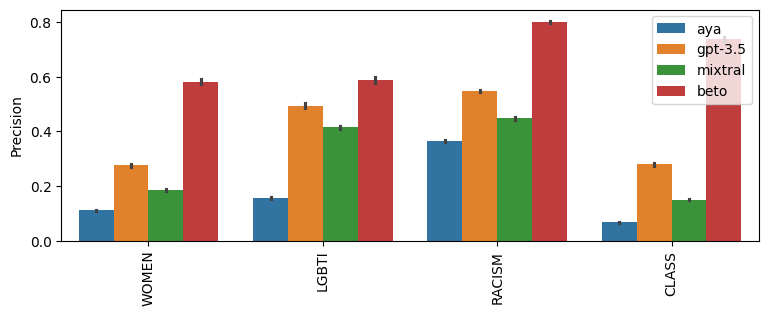

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

def plot_metric(metric, labels, legend=True):
    plt.figure(figsize=(9, 3))

    sub_df = df_metrics[(df_metrics["metric"] == metric) & (df_metrics["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


metric = "precision"
plot_metric(metric, all_labels)
plt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

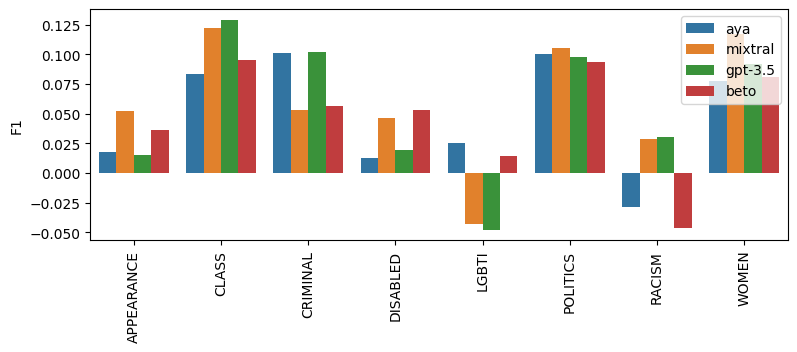

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

model_order = ["aya", "mixtral", "gpt-3.5",  "beto"]

def plot_metric(df, metric, labels, legend=True):
    plt.figure(figsize=(9, 3))

    sub_df = df[(df["metric"] == metric) & (df["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


plot_metric(diff, "f1", all_labels)
#lt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

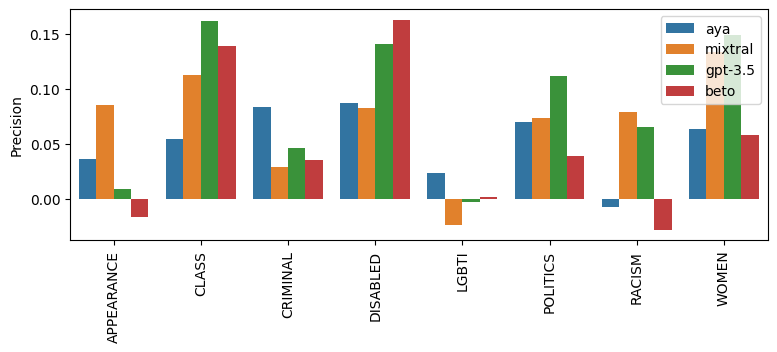

In [81]:
plot_metric(diff, "precision", all_labels)

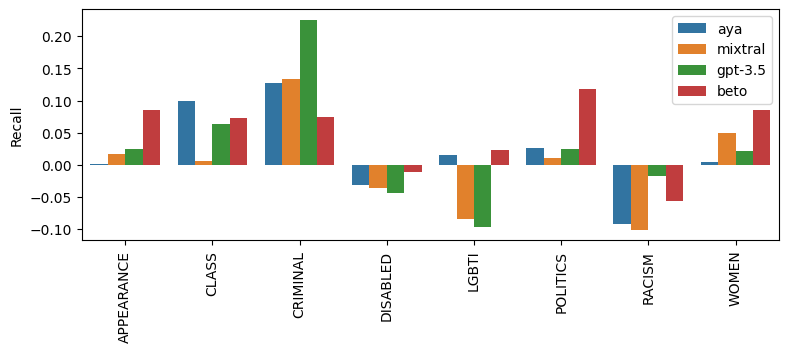

In [82]:
plot_metric(diff, "recall", all_labels)

¿Qué pasa que mejora tanto todo en CLASE?

In [8]:
df_beto = dfs["beto"]

df_beto["HATEFUL"].mean()

0.1544973544973545

In [9]:
df_beto[all_labels].sum()

WOMEN         131
LGBTI          88
RACISM        230
CLASS          76
POLITICS      144
DISABLED       66
APPEARANCE    189
CRIMINAL      185
dtype: int64

Ok! Hay muchos más odio en este conjunto de datos (cerca de 1 sobre 4) vs 1 sobre 7 en el conjunto en general

Ok, acá vemos lo siguiente:

- En CLASE, los 

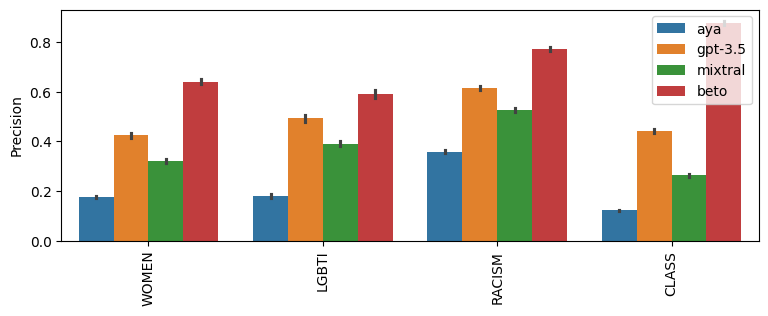

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

def plot_metric(metric, labels, legend=True):
    plt.figure(figsize=(9, 3))

    sub_df = df_metrics[(df_metrics["metric"] == metric) & (df_metrics["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


metric = "precision"
plot_metric(metric, all_labels)
#lt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

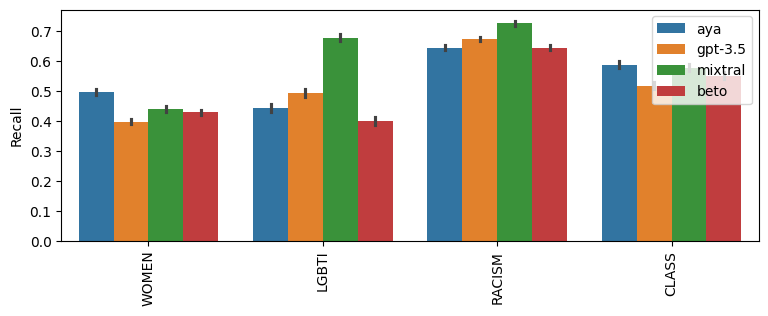

In [40]:
plot_metric("recall", all_labels)
#plt.savefig(f"img/recall.png", bbox_inches='tight', dpi=300)

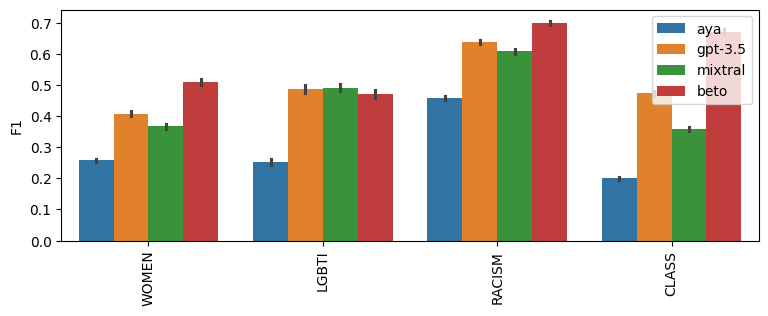

In [42]:
plot_metric("f1", all_labels)
#plt.savefig(f"img/f1.png", bbox_inches='tight', dpi=300)

In [45]:
# Just keep the most important characteristics

hate_metrics = []

# If set to True, uses all labels. If not, only WOMEN, LGBTI, RACISM, CLASS
evaluate_all = False


for name, df in dfs.items():
    if not evaluate_all:
        label_hate = df[labels].sum(axis=1) > 0
        pred_hate = df[pred_labels].sum(axis=1) > 0
    else:
        label_hate = df[all_labels].sum(axis=1) > 0
        pred_hate = df[all_pred_labels].sum(axis=1) > 0
    for metric in {"precision", "recall", "f1"}:
        if metric == "precision":
            score = precision_score
        elif metric == "recall":
            score = recall_score
        elif metric == "f1":
            score = f1_score


        gold_labels = label_hate.values
        preds = pred_hate.values

        bst = Bootstrap(metric=score, num_bootstraps=150)

        bst_scores = bst.run(preds, gold_labels)

        for score in bst_scores:
            hate_metrics.append(
                {
                    "model": name,
                    "metric": metric,
                    "score": score,
                }
            )

hate_metrics = pd.DataFrame(hate_metrics)

hate_metrics

,model,metric,score
0,gpt-3.5,f1,0.5618
1,gpt-3.5,f1,0.5519
2,gpt-3.5,f1,0.5451
3,gpt-3.5,f1,0.5702
4,gpt-3.5,f1,0.5621
...,...,...,...
1795,mixtral,precision,0.3636
1796,mixtral,precision,0.3753
1797,mixtral,precision,0.3702
1798,mixtral,precision,0.3315


([0, 1, 2], [Text(0, 0, 'f1'), Text(1, 0, 'recall'), Text(2, 0, 'precision')])

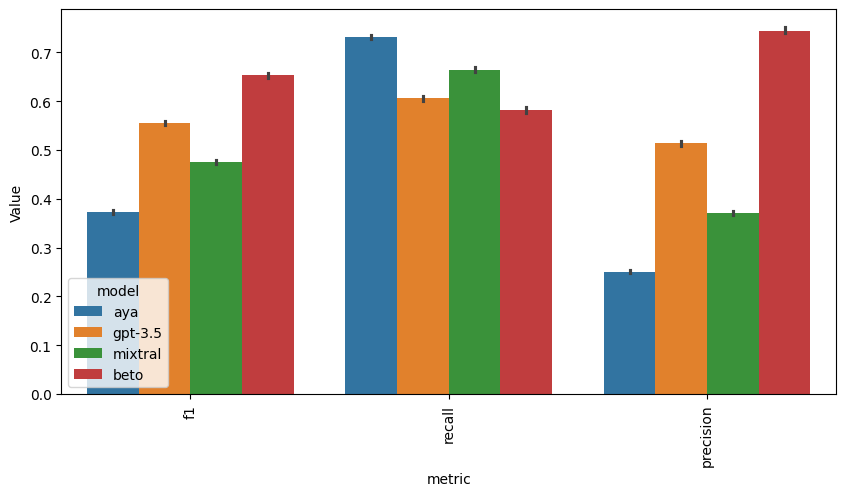

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

plt.figure(figsize=(10, 5))
sns.barplot(x='metric', y='score', hue='model', data=hate_metrics, hue_order=model_order)


plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()